R2 Score: 0.9966378137167229
RMSE: 0.536757793726433
MAE: 0.33951818475127227
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


XGBoost model with hyperparameter tuning saved to ../../XGBoost/models/xgboost_model_with_tuning.pkl
Evaluation Results for XGBoost model with tuning:
R2 Score: 0.9968659557656789
RMSE: 0.518226997298862
MAE: 0.3160014884769916
Predictions for the next 200 days saved to ../results/future_tempmax_predictions_200_days.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27312\1629015751.py:302: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data.fillna(method='bfill', inplace=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27312\1629015751.py:303: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data.fillna(method='ffill', inplace=True)


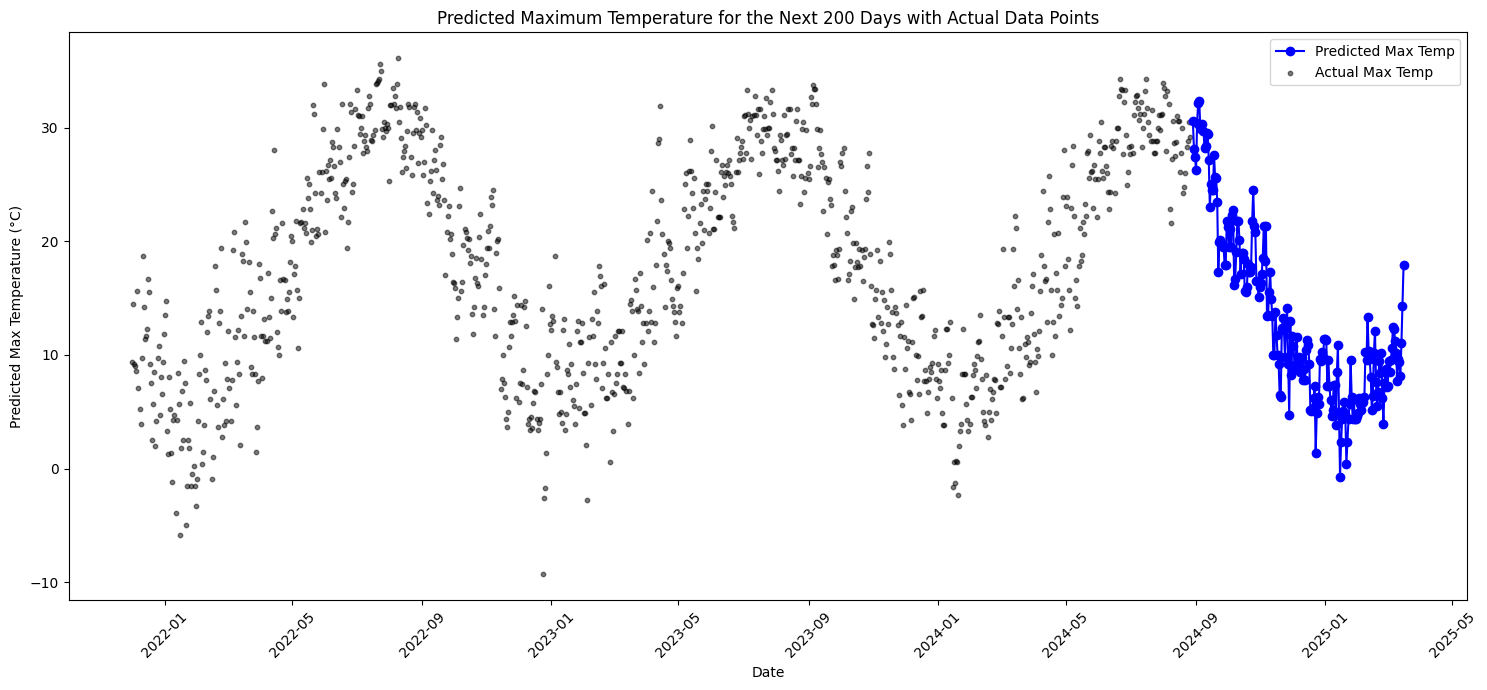

In [3]:
# Filename: /models/XGBoost/scripts/testXGBoost.ipynb

# In[0]: IMPORT AND FUNCTIONS
#region 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer  
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import joblib
import os
import pickle
#endregion

# Ensure the necessary directories exist
base_dir = "../../XGBoost"
os.makedirs(f"{base_dir}/preprocessing", exist_ok=True)
os.makedirs(f"{base_dir}/results", exist_ok=True)
os.makedirs(f"{base_dir}/figures", exist_ok=True)

# In[1]: STEP 2. GET THE DATA
file_path = "../../../data/NewYork.csv"
data = pd.read_csv(file_path)

# In[2]: HANDLE DATETIME
data['datetime'] = pd.to_datetime(data['datetime'])
data['day_of_year'] = data['datetime'].apply(lambda x: x.timetuple().tm_yday)
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year

# In[3]: DROP UNNECESSARY COLUMNS
columns_to_drop = ['name', 'stations', 'icon', 'description', 'sunrise', 'sunset', 'preciptype', 'snow', 'conditions']
data = data.drop(columns=columns_to_drop)

# In[4]: HANDLE MISSING VALUES
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# In[5]: CLUSTERING
kmeans = KMeans(n_clusters=5, random_state=42)
data['weather_cluster'] = kmeans.fit_predict(data[['temp', 'humidity', 'windspeed', 'precip']])
data = data.dropna()

# In[6]: CONVERT CATEGORICAL FEATURES TO CATEGORY TYPE
cat_feat_names = ['weather_cluster'] 

if 'weather_cluster' in data.columns:
    data[cat_feat_names] = data[cat_feat_names].astype('category')
else:
    print("Warning: 'weather_cluster' column not found. Skipping conversion to category.")

# In[7]: FEATURE ENGINEERING
# Modify or add more features based on domain knowledge
data['tempmax_lag1'] = data['tempmax'].shift(1)
data['tempmax_lag3'] = data['tempmax'].shift(3)
data['humidity_lag1'] = data['humidity'].shift(1)
data['tempmax_rolling_mean_3'] = data['tempmax'].rolling(window=3).mean()
data['tempmax_rolling_std_3'] = data['tempmax'].rolling(window=3).std()
data['precip_rolling_sum_7'] = data['precip'].rolling(window=7).sum()

# Ensure features are aligned with temperature trends
data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)

# Fill NaNs only in numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Interaction feature
data['temp_precip_interaction'] = data['temp'] * data['precip']

# In[8]: VISUALIZE RAW DATA
# Histograms for each numeric column
data.hist(bins=50, figsize=(20, 15))
plt.savefig(f"{base_dir}/figures/hist_raw_data.png")
plt.close()

# Scatter plot for a selected feature
plt.figure(figsize=(10, 6))
plt.scatter(data['humidity'], data['tempmax'], alpha=0.2)
plt.xlabel('Humidity')
plt.ylabel('Maximum Temperature')
plt.title('Scatter Plot: Humidity vs Maximum Temperature')
plt.savefig(f"{base_dir}/figures/scatter_1_feat.png")
plt.close()

# Scatter matrix for all selected features
sns.pairplot(data[[
    'tempmax', 'tempmin', 'temp', 'humidity', 
    'windspeed', 'precip', 'day_of_year_cos', 'day_of_year_sin'
]])
plt.savefig(f"{base_dir}/figures/scatter_mat_all_feat.png")
plt.close()

# In[9]: MUTUAL INFORMATION FOR FEATURE SELECTION
# Drop non-numeric columns before calculating mutual information
X = data.drop(columns=['tempmax', 'datetime'])  # Drop the target variable and datetime
y = data['tempmax']  # Target variable

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)
selected_features = mi_scores.sort_values(ascending=False).index[:20]  # Select top 20 features

# Retain only selected features
X = X[selected_features]
data = pd.concat([X, y], axis=1)

# In[10]: PIPELINE FOR DATA PROCESSING
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names]         

num_feat_names = [col for col in selected_features if col not in cat_feat_names]
cat_feat_names = ['weather_cluster'] if 'weather_cluster' in data.columns else [] 

# Numerical pipeline
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_feat_names)),
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler()) 
])  

# Categorical pipeline, if applicable
if cat_feat_names:
    cat_pipeline = Pipeline([
        ('selector', ColumnSelector(cat_feat_names)),
        ('imputer', SimpleImputer(strategy="most_frequent")),  # Most frequent for categorical data
        ('cat_encoder', OneHotEncoder(sparse_output=False))  # Set sparse_output=False for easier debugging
    ])
    full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])
else:
    full_pipeline = num_pipeline

# Process the data
processed_data = full_pipeline.fit_transform(data)

# Convert processed_data back to DataFrame with appropriate column names
processed_columns = num_feat_names
if cat_feat_names:
    onehot_columns = full_pipeline.transformer_list[1][1].named_steps['cat_encoder'].get_feature_names_out(cat_feat_names)
    processed_columns = np.concatenate([num_feat_names, onehot_columns])

# Save the processed data
processed_data_df = pd.DataFrame(processed_data, columns=processed_columns)
processed_data_path = f"{base_dir}/preprocessing/processed_data.csv"
processed_data_df.to_csv(processed_data_path, index=False)

# Save the pipeline
pipeline_path = f"{base_dir}/preprocessing/full_pipeline.pkl"
with open(pipeline_path, 'wb') as file:
    pickle.dump(full_pipeline, file)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(processed_data_df, y, test_size=0.2, random_state=42)

X_train_path = f"{base_dir}/preprocessing/X_train.csv"
X_test_path = f"{base_dir}/preprocessing/X_test.csv"
y_train_path = f"{base_dir}/preprocessing/y_train.csv"
y_test_path = f"{base_dir}/preprocessing/y_test.csv"

X_train.to_csv(X_train_path, index=False)
X_test.to_csv(X_test_path, index=False)
y_train.to_csv(y_train_path, index=False)
y_test.to_csv(y_test_path, index=False)

# In[11]: TRAIN THE XGBOOST MODEL
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, enable_categorical=True)
xgboost_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgboost_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Save evaluation metrics
with open(f"{base_dir}/results/model_evaluation.txt", "w") as file:
    file.write(f"R2 Score: {r2}\n")
    file.write(f"RMSE: {rmse}\n")
    file.write(f"MAE: {mae}\n")

print(f"R2 Score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# In[12]: HYPERPARAMETER TUNING
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 2, 3],
    'max_delta_step': [0, 1, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_grid,
    n_iter=200,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Save the best model after tuning
best_xgboost_params = random_search.best_params_
best_xgboost_model = xgb.XGBRegressor(**best_xgboost_params, objective='reg:squarederror', random_state=42, enable_categorical=True)
best_xgboost_model.fit(X_train, y_train)

model_with_tuning_path = f"{base_dir}/models/xgboost_model_with_tuning.pkl"
os.makedirs(os.path.dirname(model_with_tuning_path), exist_ok=True)

with open(model_with_tuning_path, 'wb') as file:
    pickle.dump(best_xgboost_model, file)

print(f"XGBoost model with hyperparameter tuning saved to {model_with_tuning_path}")

# In[13]: EVALUATE THE TUNED MODEL
y_pred_with_tuning = best_xgboost_model.predict(X_test)
r2_with_tuning = r2_score(y_test, y_pred_with_tuning)
rmse_with_tuning = np.sqrt(mean_squared_error(y_test, y_pred_with_tuning))
mae_with_tuning = mean_absolute_error(y_test, y_pred_with_tuning)

# Save evaluation metrics after tuning
with open(f"{base_dir}/results/model_evaluation_with_tuning.txt", "w") as file:
    file.write(f"R2 Score: {r2_with_tuning}\n")
    file.write(f"RMSE: {rmse_with_tuning}\n")
    file.write(f"MAE: {mae_with_tuning}\n")

print(f"Evaluation Results for XGBoost model with tuning:")
print(f"R2 Score: {r2_with_tuning}")
print(f"RMSE: {rmse_with_tuning}")
print(f"MAE: {mae_with_tuning}")

# In[14]: FUTURE PREDICTIONS
# Reload the original data for creating future predictions
original_data = pd.read_csv(file_path)
original_data['datetime'] = pd.to_datetime(original_data['datetime'])
original_data['day_of_year'] = original_data['datetime'].dt.dayofyear

# Generate future dates
future_days = 200
start_date = pd.to_datetime('today').normalize()
future_dates = pd.date_range(start=start_date, periods=future_days, freq='D')

# Create base DataFrame for future predictions
future_data = pd.DataFrame({'datetime': future_dates})

# Prepare historical averages
feature_columns = ['tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'humidity', 'windspeed', 'precip']
historical_averages = original_data.groupby('day_of_year')[feature_columns].mean().reset_index()

# Add 'day_of_year' to future_data
future_data['day_of_year'] = future_data['datetime'].dt.dayofyear

# Merge to get average feature values for future dates
future_data = future_data.merge(historical_averages, on='day_of_year', how='left')

# Engineer additional features similar to training data
future_data['tempmax_lag1'] = future_data['temp'].shift(1)
future_data['tempmax_lag3'] = future_data['temp'].shift(3)
future_data['humidity_lag1'] = future_data['humidity'].shift(1)
future_data['tempmax_rolling_mean_3'] = future_data['temp'].rolling(window=3).mean()
future_data['tempmax_rolling_std_3'] = future_data['temp'].rolling(window=3).std()
future_data['precip_rolling_sum_7'] = future_data['precip'].rolling(window=7).sum()
future_data['day_of_year_cos'] = np.cos(2 * np.pi * future_data['day_of_year'] / 365)
future_data['day_of_year_sin'] = np.sin(2 * np.pi * future_data['day_of_year'] / 365)
future_data['temp_precip_interaction'] = future_data['temp'] * future_data['precip']

# Ensure all required columns are present (add missing columns with zeros)
required_columns = selected_features
for col in required_columns:
    if col not in future_data.columns:
        future_data[col] = 0

# Fill missing values in future_data
future_data.fillna(method='bfill', inplace=True)
future_data.fillna(method='ffill', inplace=True)

# Process future data through the pipeline
X_future_processed = full_pipeline.transform(future_data[required_columns])

# Make predictions
future_tempmax_predictions = best_xgboost_model.predict(X_future_processed)

# Compile predictions
predictions_df = pd.DataFrame({
    'Date': future_data['datetime'],
    'Predicted_Max_Temp': future_tempmax_predictions
})

# Save predictions
predictions_df.to_csv(f"{base_dir}/results/future_tempmax_predictions_200_days.csv", index=False)
print("Predictions for the next 200 days saved to ../results/future_tempmax_predictions_200_days.csv")

# Visualization: Plot predictions and actual data
plt.figure(figsize=(15, 7))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Max_Temp'], label='Predicted Max Temp', color='blue', marker='o')
plt.scatter(original_data['datetime'], original_data['tempmax'], color='black', alpha=0.5, label='Actual Max Temp', s=10)

# Adding confidence intervals (if available)
if 'Upper_Bound' in predictions_df.columns and 'Lower_Bound' in predictions_df.columns:
    plt.fill_between(predictions_df['Date'], predictions_df['Lower_Bound'], predictions_df['Upper_Bound'], color='blue', alpha=0.2)

plt.title('Predicted Maximum Temperature for the Next 200 Days with Actual Data Points')
plt.xlabel('Date')
plt.ylabel('Predicted Max Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"{base_dir}/figures/future_tempmax_predictions_with_actual.png")
plt.show()
